# BRIEF
IT NOW CAN PERFORM REGRESSION AND multi class CLASSIFICATION



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

# Load Fashion MNIST dataset using Scikit-Learn
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
images, labels = fashion_mnist["data"], fashion_mnist["target"].astype(int)

# Normalize pixel values to the range [0, 1]
images = images.astype('float32') / 255.0

# One-hot encode the labels
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

# Reshape images from (num_samples, 784) to (num_samples, 28, 28, 1)
images = images.reshape((-1, 28 * 28))

# Split into train and test sets
train_images, test_images = images[:60000], images[60000:]
train_labels, test_labels = labels[:60000], labels[60000:]

# Convert to torch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple neural network model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 128) 
        self.tanh = nn.Tanh() # First hidden layer (784 -> 128)
        self.layer2 = nn.Linear(128, 64)    # Second hidden layer (128 -> 64)
        self.layer3 = nn.Linear(64, 10)        # Output layer (64 -> 10)                 # ReLU activation function
        self.softmax = nn.Softmax(dim=1)       # Softmax for output probabilities

    def forward(self, x):
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        return self.softmax(x)  # Softmax output

# Instantiate the model
model = FashionMNISTModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss combines Softmax and CrossEntropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_x, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(batch_y, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions * 100
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Testing the model
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            # Forward pass
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(batch_y, 1)

            # Calculate accuracy
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# Train and test the model
train(model, train_loader, criterion, optimizer, epochs=10)
test(model, test_loader)


In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Load Fashion MNIST dataset using Scikit-Learn
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
images, labels = fashion_mnist["data"], fashion_mnist["target"].astype(int)

# Normalize pixel values to the range [0, 1]
images = images.astype('float32') / 255.0

# Reshape images from (num_samples, 784) to (num_samples, 28, 28, 1)
images = images.reshape((-1, 28, 28, 1))

# Split into train and test sets
train_images, test_images = images[:60000], images[60000:]
train_labels, test_labels = labels[:60000], labels[60000:]

# One-hot encode the labels
encoder = OneHotEncoder()  # No need for sparse=False
train_labels = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels = encoder.transform(test_labels.reshape(-1, 1))

# Flatten the images to (num_samples, 28 * 28)
train_images = train_images.reshape((-1, 28 * 28))
test_images = test_images.reshape((-1, 28 * 28))

# Print shapes to verify
print("Train images shape:", train_images.shape)  # (60000, 784)
print("Train labels shape:", train_labels.shape)  # (60000, 10)
print("Test images shape:", test_images.shape)    # (10000, 784)
print("Test labels shape:", test_labels.shape)    # (10000, 10)

Train images shape: (60000, 784)
Train labels shape: (60000, 10)
Test images shape: (10000, 784)
Test labels shape: (10000, 10)


In [2]:
from core.nn import Linear, Network,batchnorm1d,Conv2d
from core.Function import tanh,relu

layer1 = Linear((784, 128),initialize_type="xavier")
tanh1 = relu()
layer2 = Linear((128, 64),initialize_type="xavier")

tanh2 = relu()
layer3 = Linear((64, 10), activation="softmax",initialize_type="xavier")
layers = [layer1,tanh1,layer2,tanh2,layer3]
model = Network(layers,classification=True)
model.train(train_images, train_labels, epochs=10, batch_size=64, learning_rate=0.01, optimizer="adam",verbose=1)

weights (784, 128)
bias (1, 128)
weights (128, 64)
bias (1, 64)
weights (64, 10)
bias (1, 10)
Epoch 10/10 | [||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% | Train Loss = 0.3880
Function train took 30.2128 seconds to execute.


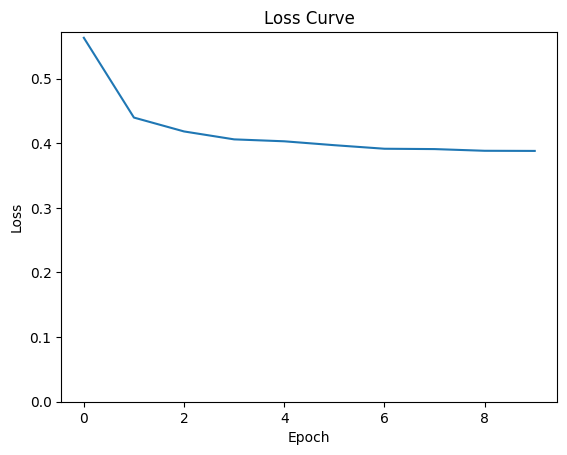

In [3]:
model.plot_loss()

In [4]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # This will give the class index for each sample
y_true_classes = np.argmax(test_labels, axis=1)  # This will give the true class index for each sample

# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_true_classes.T)
print(f"Accuracy on test set: {accuracy:.4f}")


Accuracy on test set: 0.8450
